In [ ]:
# clean the outputs env

import shutil
import os

shutil.rmtree('saved_models', ignore_errors=True)
shutil.rmtree('saved_params', ignore_errors=True)
shutil.rmtree('saved_results', ignore_errors=True)

os.mkdir('saved_models/')
os.mkdir('saved_params/')
os.mkdir('saved_results/')

shutil.rmtree('outputs', ignore_errors=True)
os.mkdir('outputs/')
os.mkdir('outputs/yeast/')

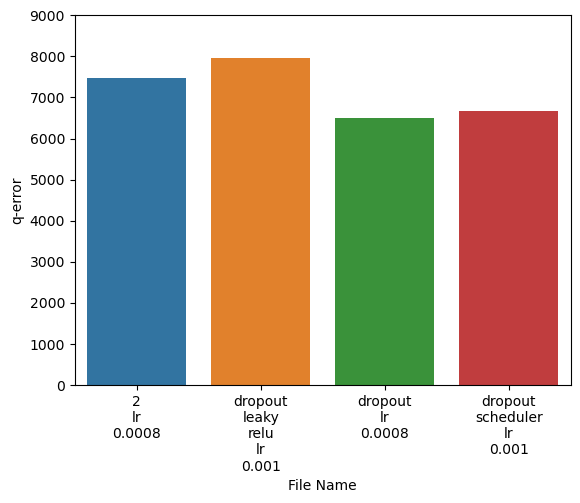

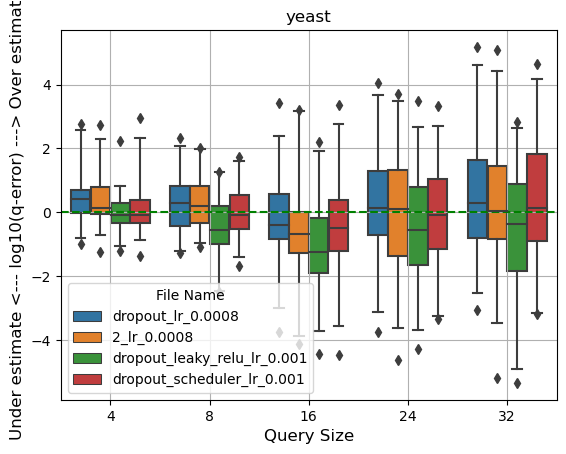

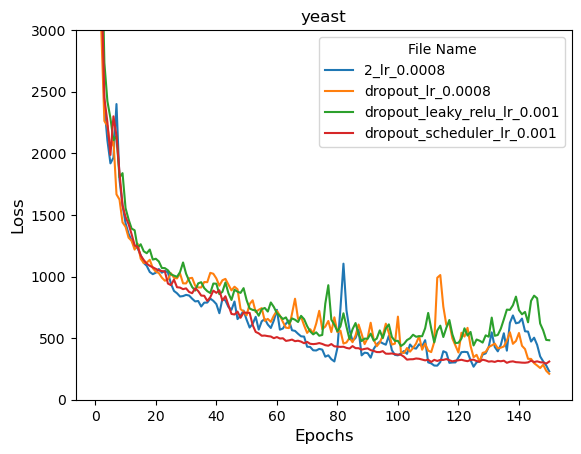

In [49]:
# draw figures for NeurSC results

import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os

def get_prediction_statistics(errors: list):
	lower, upper = np.quantile(errors, 0.25), np.quantile(errors, 0.75)
	print("<" * 80, flush=True)
	print("Predict Result Profile of {} Queries:".format(len(errors)), flush=True)
	print("Min/Max: {:.4f} / {:.4f}".format(np.min(errors), np.max(errors)), flush=True)
	print("Mean: {:.4f}".format(np.mean(errors)), flush=True)
	print("Median: {:.4f}".format(np.median(errors)), flush=True)
	print("25%/75% Quantiles: {:.4f} / {:.4f}".format(lower, upper), flush=True)
	print(">" * 80, flush=True)
	error_median = abs(upper - lower)
	return error_median

def interperting_results(file_names, test_data: pd.DataFrame, params_data: pd.DataFrame):
    test_data['q-error'] = test_data['q-error'] * math.log2(10)
    for file_name in file_names:
        q_errors = test_data[test_data['File Name'] == file_name]['q-error'].to_numpy()
        params = params_data[params_data['File Name'] == file_name]
        total_square_loss = np.sum(np.square(q_errors))
        total_l1_loss = np.sum(np.abs(q_errors))
        # print('lr: {}, epochs: {}'.format(params['Learning Rate'].to_numpy()[0], params['Epochs'].to_numpy()[0]))
        # print("Evaluation result of Eval dataset(log2 based): Total Loss= {:.4f}, Total L1 Loss= {:.4f}".format(total_square_loss, total_l1_loss))
        # get_prediction_statistics(q_errors)
        # print()

    test_data['q-error'] = test_data['q-error'] ** 2
    test_data = test_data.groupby('File Name', as_index=False).aggregate({'q-error':'sum'})
    test_data['File Name'] = test_data['File Name'].replace('_', '\n', regex=True)
    sns.barplot(test_data, x='File Name', y='q-error')
    plt.ylim(0, 9000)
    plt.show()

def read_test_file(file_name, test_dir, test_name, pure=False):
    # test_data = [['Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'], [...], ...]
    name_tokens = test_name.split('_')
    epochs = int(name_tokens[4])
    res = []
    with open(test_dir + test_name, 'r') as f:
        for line in f.readlines()[1:]:
            line_tokens = line.split()
            query_name_tokens = line_tokens[0].split('.')[0].split('_')
            query_size = int(query_name_tokens[2])
            query_type = query_name_tokens[1]
            if pure:
                pred = math.log10(float(line_tokens[2]))
                card = math.log10(float(line_tokens[3]))
            else:
                pred = float(line_tokens[2]) * math.log10(2)
                card = float(line_tokens[3]) * math.log10(2)
            q_error = pred - card
            res.append([file_name, epochs, query_size, query_type, pred, card, q_error])
    return res

def read_train_file(file_name, train_dir, train_name, pure=False):
    # train_data = [['File Name', 'Epochs', 'Loss'], [...], ...]
    res = []
    with open(train_dir + train_name, 'r') as f:
        for line in f.readlines():
            if line.startswith('Epoch '):
                tokens = line.split(' ')
                epoch = int(tokens[1].split('/')[0])
                loss = float(tokens[-1])
                res.append([file_name, epoch, loss])
    return res

def read_parameters_file(file_name, params_dir, params_name):
    # params_data = [['File Name', 'Learning Rate', 'Epochs'], [...], ...]
    res = []
    with open(params_dir + params_name) as f:
        for line in f.readlines():
            if line.startswith('learning rate'):
                lr = float(line.split(':')[1].strip())
            if line.startswith('epochs'):
                epoch = int(line.split(':')[1].strip())
    res.append([file_name, lr, epoch])
    return res

def draw_box_plot(dataframe, title, fontsize=12):
    bp = sns.boxplot(data=dataframe, x='Query Size', y='q-error', whis=[1, 99], hue='File Name')
    plt.title(title, fontsize=fontsize)
    plt.grid(True)
    plt.axhline(0, color='green',linestyle='dashed')
    plt.ylabel('Under estimate <--- log10(q-error) ---> Over estimate', fontsize=fontsize)
    plt.xlabel('Query Size', fontsize=fontsize)
    # plt.yticks(ticks=[-6, -4, -2, 0, 2, 4, 6], labels=['$10^6$', '$10^4$', '$10^2$', '$10^0$', '$10^2$', '$10^4$', '$10^6$'])
    # pcntls = df.groupby('Query Size')['q-error'].describe(percentiles=[0.1, 0.9])
    # pcntls = pcntls.sort_values(by='Query Size')
    # columns = len(pcntls['10%'])
    # bp.scatter(data=pcntls, x=range(columns), y='10%', marker='x')
    # bp.scatter(data=pcntls, x=range(columns), y='90%', marker='x')
    plt.show()

def draw_line_plot(df, title, fontsize=12):
    bp = sns.lineplot(data=df, x='Epochs', y='Loss', hue='File Name')
    plt.xlabel('Epochs', fontsize=fontsize)
    plt.ylabel('Loss', fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.ylim((0, 3000))
    plt.show()

if __name__ == '__main__':
    data_graph = 'yeast'
    test_dir = 'saved_results/'
    params_dir = 'saved_params/'
    train_dir = 'outputs/{}/'.format(data_graph)
    file_names = [
        # 'better_performance_mse_log2_0', 
        # 'better_performance_mse_log2_scheduler_0',
        # '2_lr_0.001',
        # '2_lr_0.0001',
        # '2_lr_0.0003',
        # '2_lr_0.005',
        # '2_lr_0.0005',
        '2_lr_0.0008',
        # 'dropout_lr_0.001',
        # 'dropout_lr_0.0001',
        # 'dropout_lr_0.0003',
        # 'dropout_lr_0.005',
        # 'dropout_lr_0.0005',
        'dropout_lr_0.0008',
        'dropout_leaky_relu_lr_0.001',
        # 'dropout_leaky_relu_lr_0.0001',
        # 'dropout_leaky_relu_lr_0.0003',
        # 'dropout_leaky_relu_lr_0.005',
        # 'dropout_leaky_relu_lr_0.0005',
        # 'dropout_leaky_relu_lr_0.0008',
        'dropout_scheduler_lr_0.001',
        # 'dropout_scheduler_lr_0.0001',
        # 'dropout_scheduler_lr_0.0003',
        # 'dropout_scheduler_lr_0.005',
        # 'dropout_scheduler_lr_0.0005',
        # 'dropout_scheduler_lr_0.0008',
        ]

    test_data = []
    train_data = []
    params_data = []
    for file_name in file_names:
        test_params_name = list(filter(lambda x: file_name in x, os.listdir(test_dir)))
        if len(test_params_name) != 1:
            raise Exception(test_params_name)
        train_name = list(filter(lambda x: file_name in x, os.listdir(train_dir)))
        if len(train_name) != 1:
            raise Exception(train_name)
        test_data.extend(read_test_file(file_name, test_dir, test_params_name[0]))
        params_data.extend(read_parameters_file(file_name, params_dir, test_params_name[0]))
        train_data.extend(read_train_file(file_name, train_dir, train_name[0]))

    test_data = pd.DataFrame(data=test_data, columns=['File Name', 'Epochs', 'Query Size', 'Query Type', 'Pred', 'Card', 'q-error'])
    test_data = test_data.sort_values(by='Query Size')
    train_data = pd.DataFrame(data=train_data, columns=['File Name', 'Epochs', 'Loss'])
    params_data = pd.DataFrame(data=params_data, columns=['File Name', 'Learning Rate', 'Epochs'])

    interperting_results(file_names, test_data.copy(), params_data.copy())
    draw_box_plot(test_data, data_graph)
    draw_line_plot(train_data, data_graph)

In [ ]:
import os
exist = os.listdir('./saved_results/')

for file in os.listdir('./saved_params/'):
    if file not in exist:
        os.remove('./saved_params/' + file)